# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [4]:
%load_ext autoreload
%autoreload 2
import os, sys, wave, struct
import timeit
import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget 
import scipy.signal as sig
from typing import Callable
import util as ut


from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
from fractions import Fraction


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [5]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()

def play_sound_bad(file):
    os.system(f"/usr/bin/play {file} &")
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [6]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [7]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [5]:
play = True
if play :
    play_sound_bad(sound) 


/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp3/source/caravan_48khz.wav:

 File Size: 1.61M     Bit Rate: 768k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 48000Hz      
Replaygain: off         
  Duration: 00:00:16.79  

In:4.07% 00:00:00.68 [00:00:16.10] Out:32.8k [ =====|===== ] Hd:3.4 Clip:0    

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

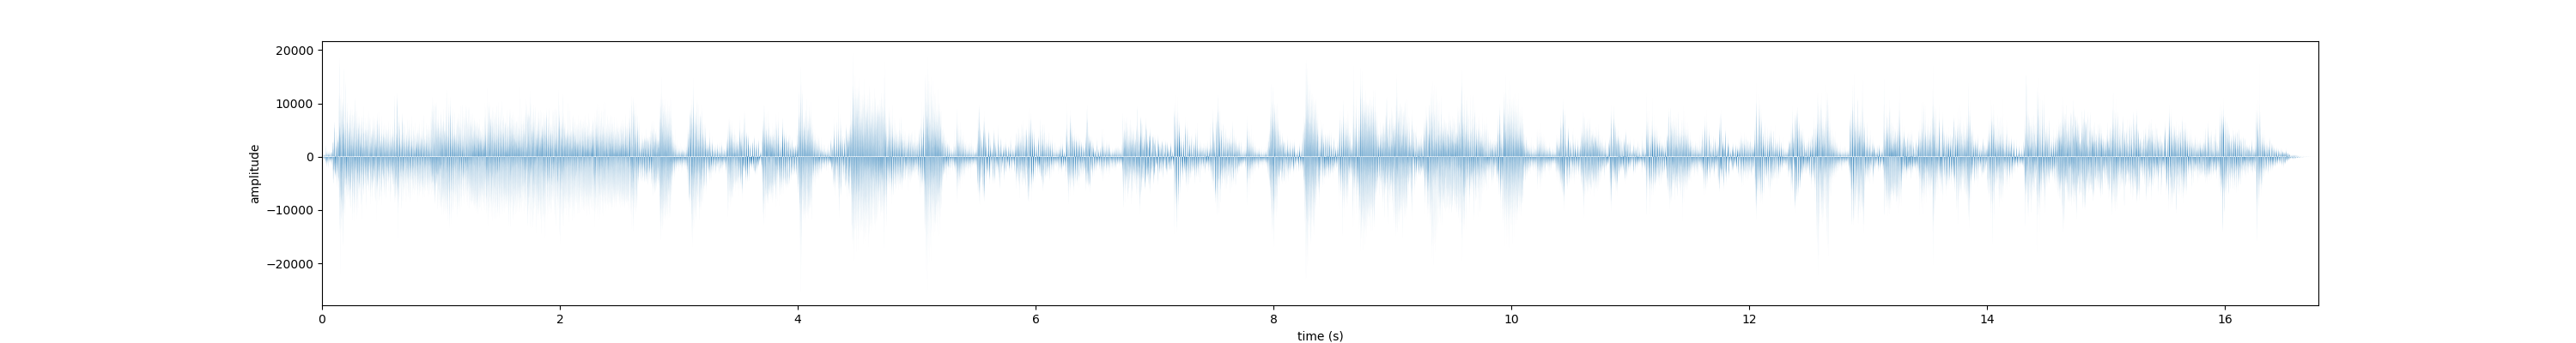

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep
plot_sound(x, times)

In [8]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Signal analysis with the STFT

In [9]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [10]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

In [11]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0, L, dtype=int),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

## Overlap-add reconstruction

In [12]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

## 2. Conversion de fréquence d'échantillonnage 

In [13]:
def plot_response(fs, width: float, h, title, log=True):
    """[summary]
    Utility function to plot response functions
    Taken from:  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    data = 20*np.log10(np.abs(h)) if log else np.abs(h)
    ax.plot(0.5*fs*width/np.pi, data)
    ylim = (-80, np.max(data)) if log else (0, np.max(data))
    ax.set_ylim(*ylim)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ylab = "Gain (dB)" if log else "Value"
    ax.set_ylabel(ylab)
    ax.set_title(title)


### Question 1

Il faut opérer un sous-échantillonnage et un sur-échantillonnage, 
en appliquant au préalable un filtre passe-bas pour éviter du repliement.

On aura donc :
- un filtre décimateur $\downarrow M$,
- un filtre ajoutant des zéros $\uparrow L$,
- un filtre passe-bas $H(e^{2j\pi\nu}) = L 1_{[-\nu_c, \nu_c]}$ avec $\nu_c = min(\frac{1}{2L}, \frac{1}{2M})$

$$
\longrightarrow \uparrow L \longrightarrow H \longrightarrow \downarrow M
$$

### Question 3

![question_3](../doc/q3.png)

### Question 4

![question_4](../doc/q4.png)

In [14]:
fs_1 = 48000 # fréquence d'échantillonnage d'entrée
fs_2 = 32000 # fréquence d'échantillonnage de sortie

frac = Fraction(fs_2, fs_1)


# Calcul de L, M, et nu_c
# Contraintes indépendantes de l'implémentation
l = frac.numerator
m = frac.denominator

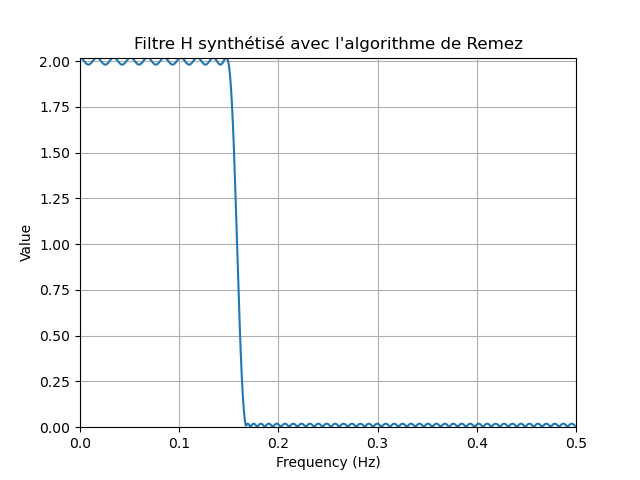

In [15]:

def get_h(l: int, m: int, delta_1: float, delta_2: float) -> np.ndarray:
    # Calculs des caractéristiques du filtre H en pratique IIR par l'algorithme de Remez.
    nu_a = min(1/(2*l), 1/(2*m)) # notre nu_c sera en fait un nu_a pour Remez
    # Calculs des caractéristiques du filtre H en pratique IIR par l'algorithme de Remez.
    w_h = nu_a * 0.1
    nu_c = nu_a - w_h # width_h = 0.02 # longueur du transitoire
    # On appliquera le filtre H passe-bas APRÈS la décimation,
    order_h = int(np.round(2/(3*(nu_a - nu_c))*np.log10(10*delta_1*delta_2)))
    # print(f"Ordre de h={order_h}")
    coef_h = sig.remez(order_h, [0, nu_c, nu_a, .5], [l, 0])
    freqs, h = sig.freqz(coef_h, [1])
    return freqs, h

delta_1 = 10 # dB
delta_2 = 10
freqs, h = get_h(l, m, delta_1, delta_2)
plot_response(1, freqs, h, "Filtre H synthétisé avec l'algorithme de Remez", log=False)

Avec $\nu_a = 0.0045$, on arrive bien à avoir $-50dB$ d'atténuation entre bande passante 

### Implémentation

In [16]:
def downsampler(m):
   return lambda x: np.copy(x[::m]) 

def upsampler(l):
    def up(x):
        x_c = np.zeros((x.shape[0] * l, * x.shape[1:]))
        r = np.arange(0, l*x.shape[0], l)
        x_c[r] = x
        return x_c
    return up

def resample_direct(x: np.ndarray, fs_1: float, fs_2: float) -> np.ndarray:
    frac = Fraction(fs_2, fs_1)

    # Calcul de L, M, et nu_c
    # Contraintes indépendantes de l'implémentation
    l = frac.numerator
    m = frac.denominator

    delta_1 = 10
    delta_2 = 10
    _, h = get_h(l, m, delta_1, delta_2)

    down = downsampler(m)
    up = upsampler(l)

    return down(np.convolve(up(x), h))

In [17]:
y = resample_direct(x, fs_1, fs_2)
print(y.shape)

(537326,)


/home/xabbu/anaconda3/envs/env_signal/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5363: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/xabbu/anaconda3/envs/env_signal/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


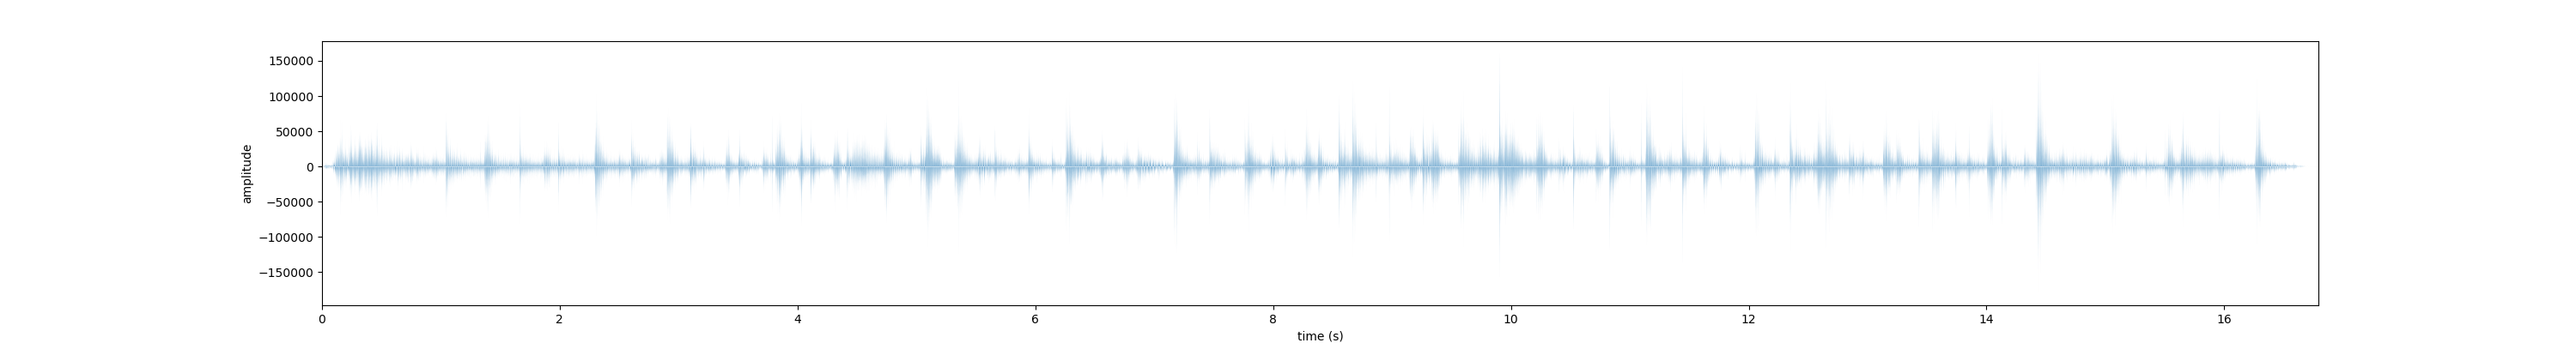

In [18]:

timestep = 1/float(fs_2)
times = np.arange(len(y))*timestep
plot_sound(y, times)
play = True
if play:
    ut.play(y, fs_2)

In [ ]:
def delay(x: np.ndarray, n: int) -> np.ndarray:
    y = np.empty_like(x)
    y[:n] = 0
    y[n:] = x[n:]
    return y

def delay_z(x_z: np.ndarray, n: int) -> np.ndarray:
    z = np.exp(2 * j * np.pi)
    return x_z * (z ** n)

def resample_efficient(x: np.ndarray, fs_1: float, fs_2: float) -> np.ndarray:
    frac = Fraction(fs_2, fs_1)

    # Calcul de L, M, et nu_c
    # Contraintes indépendantes de l'implémentation
    l = frac.numerator
    m = frac.denominator

    delta_1 = 10
    delta_2 = 10
    _, h = get_h(l, m, delta_1, delta_2)

    down = downsampler(m)
    up = upsampler(l)

    # On peut remarquer que la formule fonctionne pour tout l et m.
    r = ut.polyphase_ii(h, l)
    a = np.empty((l, ((x.shape[0]+1)//m + r.shape[1]//m - 1)*l))
    for k in range(l):
        e_r = ut.polyphase_i(r[k], m)
        b = np.array([np.convolve(down(delay(x, j)), e_r[j]) for j in np.arange(m)])
        a[k] = delay(up(np.sum(b, axis=0)), l - 1 - k)
    y = np.sum(a, axis=0)
    return y

def resample_efficient_z(x: np.ndarray, fs_1: float, fs_2: float) -> np.ndarray:
    frac = Fraction(fs_2, fs_1)

    # Calcul de L, M, et nu_c
    # Contraintes indépendantes de l'implémentation
    l = frac.numerator
    m = frac.denominator

    delta_1 = 10
    delta_2 = 10
    _, h = get_h(l, m, delta_1, delta_2)
    

    down = downsampler(m)
    up = upsampler(l)

    # On peut remarquer que la formule fonctionne pour tout l et m.
    r = ut.polyphase_ii(h, l)
    a = np.empty((l, ((x.shape[0]+1)//m + r.shape[1]//m - 1)*l))
    for k in range(l):
        e_r = ut.polyphase_i(r[k], m)
        b = np.array([np.convolve(down(delay(x, j)), e_r[j]) for j in np.arange(m)])
        a[k] = delay(up(np.sum(b, axis=0)), l - 1 - k)
    y = np.sum(a, axis=0)
    return y

In [ ]:
y = resample_efficient(x, fs_1, fs_2)

In [ ]:
timestep = 1/float(fs_2)
times = np.arange(len(y))*timestep
plot_sound(y, times)
play = True
if play:
    ut.play(y, fs_2)

In [ ]:
t_direct = timeit.timeit(lambda : resample_direct(x, fs_1, fs_2), number=10)
t_eff = timeit.timeit(lambda : resample_efficient(x, fs_1, fs_2), number=10)
print(f"Direct: {t_direct}s -- Efficient: {t_eff}s")

À l'oreille, le résultat est moins bon dans l'implémentation efficace, mais le temps de calcul est moindre. On pourra choisir entre les deux selon la contrainte la plus importante entre qualité et temps.

## 3. Égalisation audio par TFCT

In [ ]:
n_w = 80
m_w = n_w + 10
w = sig.windows.hann(n_w)
w_ft = np.fft.fft(w, n=m_w)
w_ft_log = 20 * np.log10(np.abs(w_ft))
plt.plot(np.fft.fftfreq(m_w), np.abs(w_ft_log))

Soit $w$ la fenêtre de Hann de longueur $N_w$, on a :
$$
w(n) = \frac{1}{2} \left (1 - \cos(\frac{2 \pi n}{N_w-1}) \right)
$$

La largeur du lobe principal est $\frac{4}{N_w}$.


$$
W_X(\lambda, b) = \sum_{n\in\Z} x(n) w(n-b)e^{-2j\pi \lambda n}
= \left (x * h \right )(b) e^{2j\pi \lambda b}
$$
Avec :
$$
h(n) = w(-n)e^{2j\pi \lambda n} = w(n)e^{2j\pi \lambda n}
$$
$$
H_R(\nu)= TF(h)(\nu) = \sum_{n} w(n) e^{-2j\pi n(\nu - \lambda)} = W(\nu - \lambda)
\\
H(\nu) = H_N(\nu) e^{2j\pi\lambda b}
$$

Il s'agit d'un filtrage par $H$, un filtre  passe-bas. 
Il serait RIF à phase linéaire (en fait constante) si l'on ignore 
le déphasage de $H_R$ de $\lambda$. 
$$
d = e^{2j\pi \lambda b}
$$
Si $\lambda b \equiv 0 [\frac{\pi}{2}]$ alors $d=1$, 
si $\lambda b \equiv \frac{\pi}{8}  [\frac{\pi}{2}]$ alors $d=i$.
$w$ est paire (symétrique), donc si sa longueur est paire, $H$ est de type II,
sinon $H$ est de type I.


On a :
$$
\tilde{X}(\lambda, b) = (x * h)(b) = W_X(x, b) e^{-2j\pi\lambda b}
$$

In [ ]:
def stft_comp(x: np.ndarray, w: np.ndarray, m: int, r: int) -> Callable[[int, int], np.ndarray]:
    def x_tilde(k: int, u: int) -> np.ndarray:
        n = np.arange(min(len(w), len(x) - u * r))
        x_p = x[n + u * r]
        return np.sum(x_p * w * np.exp(-2j * np.pi * k * n / m))

    return x_tilde

Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
r = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
m = 32 # ordre de la tfd
k = 3
comp = stft_comp(x, w, m, r)
# 400 premiers échantillons pour un calcul plus rapide.
# attention : affreusement long autrement.
ts = np.arange(800000) 
x_k = np.array([comp(k, u) for u in ts])

In [ ]:
# f, t, spectrum = sig.spectrogram(x_k)
# plt.pcolormesh(t, f, np.abs(spectrum))
play = False
if play:
    ut.play(x_k.real)

$x_k$ est complexe, et correspond bien à une bande de fréquence de x

## 3.2 Reconstruction

Par le calcul, on trouve :
$$
y(n) = \frac{1}{M} \sum_{k=0}^{M-1} x(n) \sum_{u \in \Z} w(n - uR)w_s(n-uR)
= \frac{1}{M} \sum_{k=0}^{M-1} x(n)f(n)
$$
Soit si $f(n) = 1 \forall n$ alors $y(n) = x(n)$.

In [26]:

n_w = 512
w_s = sig.windows.hann(n_w)
w_aux = np.pad(w, (x.shape[0]*r, x.shape[0]*r))
w_norm = np.array([np.sum(w_aux[i - np.arange(x.shape[0]) * r]) for i in np.arange(x.shape[0])])
w_p = w_aux / w_norm
w_p = w_p[x.shape[0]*r:-x.shape[0]*r]

r = n_w//4 # Recouvrement de 75%

y = ola(w_p, r)

err = np.linalg.norm(x - y)
print(err)

## 3.3 Égaliseur Audio à TFCT

In [ ]:
def equalise_stft(x: np.ndarray, w: np.ndarray, weights: np.ndarray, m: int, r: int) -> np.ndarray:
    comp = stft_comp(x, w, m, r) 
    # Iy_tilde_k = np.array([comp(k, u)])
    pass
